In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter

In [2]:
'''table 
The following function automates the process of constructing FCF statement of a company for the next 10 years
Based on the following parameters:
- Revenue Growth Rate (rev_g)
- Operation expense growth rate (op_exp_g)
- Capital expenditure growth rate (cap_exp_g)
- SG&A growth rate (sga_r)
- Depreciation rate (dep_r)
- Tax rate (tax_r)
The reasons for the values chosen behind these rates is given in the Table 1 of the project
'''
def FCF_forecaster(rev_g,op_exp_g,cap_exp_g,sga_r,dep_r,tax_r):
    #revenue estimation
    revenue_lst = [1000000]
    for i in range(9):
        revenue_lst.append(revenue_lst[-1]*(1+rev_g))
    #print(revenue_lst)
    revenue_lst
    
    # Operating expense
    op_exp_lst = []
    for i in range(len(revenue_lst)):
        op_exp_lst.append(revenue_lst[i]*(op_exp_g-0.06*i))
    op_exp_lst 

    # capital expense
    cap_exp_lst = []
    for i in range(len(revenue_lst)):
        cap_exp_lst.append(revenue_lst[i]*(cap_exp_g-0.03*i))
    cap_exp_lst, revenue_lst

    #SG&A estimation 
    sga_lst = []
    for i in range(len(revenue_lst)):
        sga_lst.append(revenue_lst[i]*(sga_r))
    sga_lst

    #Depreciation estimation
    dep_lst = []
    for i in range(len(revenue_lst)):
        dep_lst.append(revenue_lst[i]*(dep_r))
    dep_lst

    #taxable income calculation
    tax_in_lst = []
    for i in range(len(revenue_lst)):
        tax_in_lst.append(revenue_lst[i]-op_exp_lst[i]-cap_exp_lst[i]-sga_lst[i]-dep_lst[i])
    tax_in_lst

    #taxes calculation 
    tax_lst = []
    for i in range(len(tax_in_lst)):
        #if statement to check if income is postive otherwise no tax
        if tax_in_lst[i] >= 0:
            tax_lst.append(tax_in_lst[i]*tax_r)
        else:
            tax_lst.append(0)
    tax_lst    

    #net income calculation 
    net_income_lst = []
    for i in range(len(tax_in_lst)):
        net_income_lst.append(tax_in_lst[i]-tax_lst[i])
    net_income_lst

    FCF_lst = []
    for i in range(len(net_income_lst)):
        FCF_lst.append(net_income_lst[i]+dep_lst[i])
    return(revenue_lst, op_exp_lst, cap_exp_lst, sga_lst, dep_lst, tax_in_lst, tax_lst, net_income_lst, FCF_lst)


In [3]:
'''
The following function performs the simualtion.
This function calls the FCF_forecast function several times to build the FCF statements.
These statements are built by random sampling of key uncertain variables:
- Revenue Growth 
- Operational Expense Growth
- Weighted Average Cost of Capital (WACC)
'''
def valuation_simulation(sims):
    #initializing company value list
    company_value = []
    for i in range (sims):
        #normal distribution of revenue growth with mean 54% and standard deviation of 5%
        rand_rev_g = np.random.normal(0.54,0.05)
        rand_op_exp_g = np.random.normal(0.8,0.05)
        
        # Using FCF_forecaster function to get the FCF
        lst = FCF_forecaster(rev_g = rand_rev_g, op_exp_g = rand_op_exp_g,cap_exp_g = 0.4,sga_r = 0.15,dep_r = 0.05,tax_r = 0.35)
        FCF_lst = lst[-1]
        WACC = np.random.normal(0.075,0.005)
        # NPV OF CASH FLOWS
        npv = np.npv(WACC, FCF_lst)
        #calculating terminal value
        terminal_value = ((FCF_lst[-1])/((1+WACC)+(WACC-0.025)))
        
        #discounting the terminal value to get the present value 
        terminal_value_discounted = terminal_value/(1-WACC)**10
        
        #calculating the company value 
        company_value.append(terminal_value_discounted + npv)
    
    #returns the list of the multiple valuations of the company 
    return(company_value)

In [4]:
'''
The following function converts the python lists into first panda dataframe
Then it converts into an excel file
The reason being this model tries to make the output of the valuation results as easy as possible for the potential stakeholders
'''
def python_excel_covert(lst):
    # dataframe columns
    df = pd.DataFrame({'Sales': lst[0],
                    'Operating Expense': lst[1],
                    'Capital Expenses' : lst[2], 
                    'SG&A' : lst[3],
                    'Depreciation' : lst[4],
                    'Taxable income' : lst[5],
                    'Taxes' : lst[6],
                    'NOPAT' : lst[7],
                    'FCF' : lst[8]})

    npv = np.npv(0.075, lst[8])
    df1 = pd.DataFrame({'NPV' : [npv]})

    df = pd.concat([df,df1], axis=1)

    df = df.transpose()

    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter('FCF Statement.xlsx', engine='xlsxwriter') 

    # Convert the dataframe to an XlsxWriter Excel object.
    df.to_excel(writer, sheet_name='Sheet1', index=True)

    #worksheet.write(1, 0, 1234.56)  # Writes a float

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()

In [5]:
# the inputs for the FCF statement projections
rev_g = 0.52 # revenue growth rate 
op_exp_g = 0.8 # Operating Expense as 80% of revenues decreasing to 20% by 2030
cap_exp_g = 0.4 # Capital Expense as 40% of revenues decreasing to 10% by 2030
sga_r = 0.15 # SG&A as 15% of revenues 
dep_r = 0.05 # Depreciation as 5% of total revenues 
tax_r = 0.35 # 35% tax rate

lst = FCF_forecaster(rev_g = rev_g, op_exp_g = op_exp_g, cap_exp_g = 0.4,sga_r = 0.15,dep_r = 0.05,tax_r = 0.35)
python_excel_covert(lst)

In [6]:
'''
The following function builds the histograms by taking in the list of multiple valuations from the FCF statement
'''
def plot_hist(sim):
    plt.figure(figsize=(8, 6))
    plt.title('Histogram of multiple valuations')
    plt.xlabel('Valuation')
    plt.ylabel('Frequency')
    plt.hist(sim, bins = 100)
    mean = np.mean(sim)
    stdev = np.std(sim)
    plt.axvline(mean, color='orange', linestyle='-', label=f'mean = {mean:.1f}')
    plt.axvline(mean + stdev, color='red', linestyle='--', label=f'1 stdev = {stdev:.1f}')
    plt.axvline(mean - stdev, color='red', linestyle='--')
    plt.legend()
    plt.show()

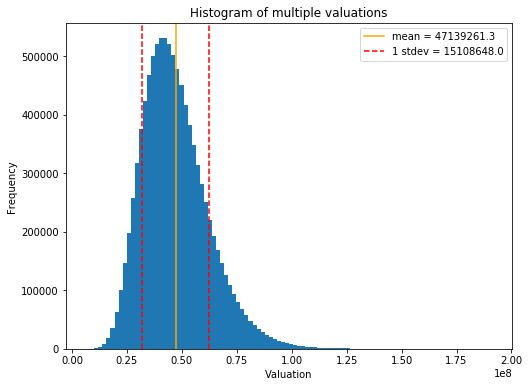

In [7]:
#Number of simulations
sims = 10000000
sim = valuation_simulation(sims)
plot_hist(sim)